<a href="https://colab.research.google.com/github/giacomogreggio/Algoritmi_avanzati/blob/master/Alg_Av_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is a python notebook containing the execution of the second homework of the course "Advanced Algorithms 2019/2020".

In this notebook we will analize the "Traveling Salesman Problem" (TSP) that is an unfeasable problem, by focusing on execution times and quality of solutions.

In particular we will implement and analize the following algorithms:

* the exact algorithm of Held and Karp
* Closest Insertion as a constructive heuristic
* 2-approximation algorithm


## Hamiltonian cycle

An hamiltonian cycle is a cycle in which we go trough each node of the graph only one time.

## Travelling Salesman Problem (TSP)
The "Travelling Salesman problem" consist in finding the hamiltonian cycle that goes trough all nodes of minimum cost in a complete graph.

# Importing the dependencies

In [0]:
from math import pi, cos, acos, sqrt, inf
import time
from google.colab import drive
import random
import os
import matplotlib.pylab as plt
%matplotlib inline
import copy
import pandas as pd
import numpy as np
import sys

# Notebook configuration

This section contains the configuration needed to run this notebook.
First you need to upload the datasets where all the algorithms will be run to a folder on google drive
Next please mount your google drive by following the instructions that will be described below

In [0]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Please set the following variable to the path of the folder where you uploaded all the datasets

In [0]:
dataset_path="/content/drive/My Drive/Colab Notebooks/algoritmi_avanzati/Homework_2/dataset/"

Since Held and Karp is a recursive method we needed to increase the recursion depth to run it on the biggest datasets. Please set the recursion limit to a proper value.

In [0]:
sys.setrecursionlimit(5000)

# Defining data structures

## Importing from the previous homework

We start by importing a couple of classes that we definec in the previous homework, and that will be useful to implement the 2-approximation algorithm.

### Edge class
The class that we used to represent the edges of the graph

In [0]:
class Edge:
    def __init__(self, node1,node2, weight=None):
        self.node1=node1
        self.node2=node2
        self.weight=weight

    def to_string(self):
        print("Edge : {} , weight : {}".format(str(self.node1) + " " + str(self.node2), self.weight))

### HeapNode class

The class that we used to represent the single node of the heap structure. In particular, each node has two parameters: its name and its weight.

In [0]:
class HeapNode:
  def __init__(self, node, weight):
    self.node=node
    self.weight=weight

### MinHeap class

The class that we used to represent MinHeap data structure. The structure is described as follow:

  * **__init__**: Given a list of HeapNodes initializes the heap.  Complexity: O(n*log(n))

  * **left**: Returns the position of the left child of a node. Complexity:O(1)

  * **right**: Returns the position of the right child of a node. Complexity:O(1)

  * **parent**: Returns the position of the father of a node. Complexity: O(1)

  * **min_heapify**: Given the root of a binary tree, if both the left and right subtrees of the root are min heap data structures this method converts the entire tree to a min heap. Complexity:O(log(n))

  * **insert**: Adds a new node to the heap data structure. Complexity:O(log(n))

  * **delete**: Deletes an element from the list and returns it. Complexity:O(log(n))

  * **modify**: Modifies the weight value of a node and restores the properties of the min-heap tree. Complexity:O(log(n))

  * **correct**: Checks the correctness of the heap. Complexity:O(n)

  * **extact_min**: Deletes and returns from the heap the node with the minimum weight value. Complexity:O(log(n))

  * **contains_node**: Checks if a node is contained inside the heap. Complexity:O(1)

  * **empty**: Returns true if the structure is empty. Complexity:O(1)

  * **get_key**: Returns the key of a node given its name. Complexity:O(1)

  * **min_heapify_up**: Does the inverse process of the _min_heapify()_ method. 
While _min_heapify()_ makes a node descend the tree, the _min_heapify_up()_ makes it ascend. It's used only inside the _modify()_ method when the weight is lower than the previous. Complexity:O(log(n)).

In [0]:
class MinHeap:
  def __init__(self, list_of_nodes):
    self.positions = {}
    self.nodes = list_of_nodes
    self.heap_size = len(list_of_nodes)
    self.nodes.insert(0, inf)
    for i in range(1, len(self.nodes)):
        self.positions[self.nodes[i].node] = i
    for i in range(int(self.heap_size/2), 0, -1):
      self.min_heapify(i)

  def left(self,i):
    return 2*i

  def right(self,i):
    return 2*i+1

  def parent(self,i):
    return int(i/2)

  def min_heapify(self, i):
    if self.heap_size < 2:
        return
    while i <= int(self.heap_size)/2:
        l, r = self.left(i), self.right(i)
        # Checking the minimum between the root and it's two childrens
        minimum = l if l <= self.heap_size and self.nodes[l].weight < self.nodes[i].weight else i
        if r <= self.heap_size and self.nodes[r].weight < self.nodes[minimum].weight:
            minimum = r
        if minimum == i: # if it's the minimum interrupt the execution
            break

        temp = self.nodes[i]

        self.nodes[i] = self.nodes[minimum]
        self.positions[self.nodes[i].node] = i

        self.nodes[minimum] = temp
        self.positions[self.nodes[minimum].node] = minimum

        i = minimum
        
  def insert(self, heap_node):
    self.heap_size += 1
    i = self.heap_size
    self.positions[heap_node.node] = i
    self.nodes.append(heap_node)
    self.min_heapify_up(i)
  
  def delete(self, node_name):
    pos = self.positions[node_name]
    deleted_node = self.nodes[pos] 
    self.nodes[pos] = self.nodes[self.heap_size]
    self.positions[self.nodes[pos].node] = pos
    del self.nodes[self.heap_size]
    del self.positions[node_name]
    self.heap_size -= 1
    self.min_heapify(pos)
    return deleted_node

  def modify(self, heap_node):
    i = self.positions[heap_node.node]
    p = self.parent(i)
    self.nodes[i].weight = heap_node.weight
    if p > 0 and self.nodes[p].weight > heap_node.weight:
        self.min_heapify_up(i)
    else:
        self.min_heapify(i)

  def correct(self):
    for i in range(1, int(self.heap_size/2)):
      l = self.left(i)
      r = self.right(i)
      act_weight = self.nodes[i].weight
      if act_weight > self.nodes[l].weight or (r > self.heap_size and self.nodes[r].weight != inf) or (r <= self.heap_size and self.nodes[r].weight < act_weight):
        return False
    return True

  def extract_min(self):
    return self.delete(self.nodes[1].node)

  def contains_node(self, name):
      return name in self.positions

  def empty(self):
      return self.heap_size == 0

  def get_key(self, node):
    return self.nodes[self.positions[node]].weight
    
  def min_heapify_up(self, i):
    if i < 2:
      return
    act = self.nodes[i]
    p = self.parent(i)
    while p > 0 and self.nodes[p].weight > self.nodes[i].weight:
      temp = self.nodes[i]

      self.nodes[i] = self.nodes[p]
      self.positions[self.nodes[i].node] = i

      self.nodes[p] = temp
      self.positions[self.nodes[p].node] = p
      i = p
      p = self.parent(i)

### Prim algorithm

In [0]:
def prim(start, edge_list, node_names, weights):
  parents, heap_nodes = {}, []
  # O(n)
  for i in range(1,len(node_names)+1):
    heap_nodes.append(HeapNode(i,inf)) # O(1)

  heap_nodes[int(start) - 1].weight = 0 # O(1)
  Q = MinHeap(heap_nodes)  # O(nlogn)
  # O(n)
  while not Q.empty():
    u = Q.extract_min().node # O(logn)
    for v in node_names: # O(m)
        v = int(v)
        if v != u:
            w = weights.get_weight(u, v)
            if Q.contains_node(v) and w < Q.get_key(v): # O(1)
                parents[v] = {"parent": u, "weight": w } # O(1)
                Q.modify(HeapNode(v, w)) # O(2logn)
  return parents

### Weights class

Weights is a class that cointains the weights relative to each edge of the graph.

The class has the following methods:

* **get_edge_name**: passing the name of two vertexes as parameters and returns a unique identifier for the edge incident on those two vertexes.
* **add_weight**: given the name of two vertexes and a weight, adds to the data structure the edge incident on those vertexes with that weight.
* **get_weight**: give the name of two vertexes of an edge, returns that edge's weight.

In [0]:
class Weights:
    def __init__(self):
        self.weights = {}

    def get_edge_name(self, a, b):
        return str(a) + " " + str(b) if int(a) < int(b) else str(b) + " " + str(a)

    #Adds the weight if not present otherwise does nothing
    def add_weight(self, a, b, weight):
        name = self.get_edge_name(a,b)
        if name not in self.weights or self.weights[name] > weight:
            self.weights[name]=weight
            
    #Given two nodes returns the weight of the edge
    def get_weight(self, a, b):
        name = self.get_edge_name(a,b)
        return self.weights[name]

## Distance methods

The following methods will be used to calculate the Geographic distance and Euclidean distance between two coordinates.

### Euclidean distance
This method calculates the euclidean distance, given the coordiantes of two points.

In [0]:
def euclidean_distance(coord1, coord2):
    return sqrt(sum([(a - b) ** 2 for a, b in zip(coord1, coord2)]))

### Convert to radiant
Given the latitude and longitude of a geographic point, this method converts them to radiants.

In [0]:
def convert_to_rad(coords):
    return [ (pi * (int(coord) + 5.0 * (coord - int(coord)) / 3.0) / 180.0) for coord in coords ]

### Geographic distance

This method calculates the geographic distance, given the coordiantes in radiants of two points.

**RRR** is a constant needed to calculate the geographic distance between two points.

In [0]:
RRR = 6378.388

def geographic_distance(coord1, coord2):
    q1, q2, q3 = cos( coord1[1] - coord2[1] ), cos( coord1[0] - coord2[0] ), cos( coord1[0] + coord2[0] )
    return int( RRR * acos( 0.5*((1.0+q1)*q2 - (1.0-q1)*q3) ) + 1.0)

## Importing graph from dataset

The following method aims to import a graph by creating some structures needed to run the following methods.

**INPUT** : 

* **dataset_path**: path to the dataset file where we want to run our algorithms.

**OUTPUT** :

* **node_names**: list of all string names of our nodes.
* **weights**: an instance of the data structure discussed above. For each pair of vertexes we calculate their geographic or euclidean distance and we add it to such data structure.
* **edge_list**: list of edge classes that we will use for 2-approximation algorithm.


In [0]:
def import_graph(dataset_path):
    dataset = open(dataset_path,"r").read().split("\n")

    '''
      this cycle reads the type of the coordinates and sets the
      variable i to the row of the first point in the dataset,
      since the number of rows before the first pair of coordinates 
      varies between dataset
    '''
    i = 0
    while not dataset[i].startswith("NODE_COORD_SECTION"):
        if dataset[i].startswith("EDGE_WEIGHT_TYPE"):
            type_coords = dataset[i].split(":")[1][1:]
        i = i + 1
    i = i + 1

    node_names, coordinates, weights, edge_list = [], {}, Weights(), []
    '''
      for each point in the dataset, we store its name and its coordinates
    '''
    for j in range(i, len(dataset)):
        row = dataset[j].split()
        if len(row) != 3:
            break
        name, x, y = str(row[0]), float(row[1]), float(row[2])
        node_names.append(name)
        coordinates[name] = [x, y] if type_coords == "EUC_2D" else convert_to_rad([x, y])
    
    '''
      depending on the type of the coordinates, we store the appropriate
      function that calculates the distance between points
    '''
    distance_function = euclidean_distance if type_coords == "EUC_2D" else geographic_distance
    '''
      starting from the coordinates that we gathered before, for each pair of 
      points we calculate their distance and store it in the weights data 
      structure as an edge
    '''
    for i in range(len(node_names)):
        for j in range(1 + i, len(node_names)):
            weights.add_weight(node_names[i], node_names[j], distance_function(coordinates[node_names[i]], coordinates[node_names[j]]))
            edge_list.append(Edge(int(node_names[i]), int(node_names[j]), weights.get_weight(node_names[i], node_names[j])))

    return node_names, weights, edge_list

# Held and Karp

Held and Karp is a dynamic algorithm that aims to calculate the minimum circuit that solves the TSP problem. On each iteration, given a node **v** and a subset of nodes **S**, it returns the weight of the minimum path that reaches **v** by starting from a particular node and goes through all nodes belonging to **S**.

Since the method has a complexity of O($2^n$), we stop it if it exceeds a certain time threshold.  
We decided to stop the method after two minutes.

In [0]:
def held_karp(v, S, time_threshold):
    '''
      since we need a unique way to identify each pair v,S we decided 
      to create a string by printing all the elements of the subset S
      and the node v divided by a space.
    '''
    subset_name = ''.join(S) + " " + str(v)
    if len(S) == 1 and v in S:
        return weights.get_weight(starting_node, v)
    elif subset_name in d:
        return d[subset_name]

    # copy the set S and remove the element v
    mindist, minprec, node_names_copy = inf, None, copy.deepcopy(S)
    node_names_copy.remove(v)

    for u in node_names_copy:
        # interrupt the for if the time has passed the threshold
        if time.time() > time_threshold:
            break
        dist = held_karp(u, node_names_copy, time_threshold)
        uv_weight = weights.get_weight(u, v)
        if dist + uv_weight < mindist:
            mindist, minprec = dist + uv_weight, u
    d[subset_name], p[subset_name] = mindist, minprec
    '''
      Returns the truncated minimum distance if the algorithm has found a solution
      otherwise returns inf.
    '''
    return int(mindist) if mindist != inf else inf

# Closest Insertion

Given a set of vertexes _C $\subseteq$ V_, which represents a partial circuit, and a vertex _k$\notin$C_, we define the distance of _k_ from _C_ as the minimum weight of an edge which connects _k_ to _C_.
The delta method is an implementation of that function. 


In [0]:
def delta(k, C):
    min_dist, min_index = inf, -1
    for c in range(len(C)): # O(|C|)
        dist = weights.get_weight(C[c], k)
        if dist < min_dist:
            min_dist = dist
            min_index = C[c]
    return min_dist, min_index

Closest Insertion is a constructive heuristic which picks on each iteration a node by following specific rules. In particular, this heuristic is composed by the following steps:

* **Initialization**: starts from the circuit containing only the starting node, the algorithm finds a vertex j that minimizes _w(0,j)_ and builds the partial circuit _(0,j,0)_.

* **Selection**: finds a vertex _k$\notin$C_, which minimizes the function **delta(k,C)** defined above.

* **Insertion**: finds an edge _{i,j}$\in$C_, which minimizes the value _w(i,k) + w(k,j) - w(i,j)_ and insert _k_ between _i_ and _j_.

Repeats **Selection** and **Insertion** until it has inserted all the nodes of the graph.

In [0]:
def closest_insertion():
    '''
      Initialization
    '''
    node_names_copy = copy.deepcopy(node_names) # copying set of nodes
    node_names_copy.remove(starting_node) # removing first node
    min_dist_first, min_index_first = delta(starting_node, node_names_copy)
    C = [ starting_node, min_index_first, starting_node ] # creating initial partial circuit (0,j,0) 
    node_names_copy.remove(min_index_first) # removing node j from the set
    solution = min_dist_first * 2 # initializing initial solution weight

    while not len(node_names_copy) == 0:
        '''
          Selection
        '''
        min_dist, min_index = inf, -1
        # finding k that minimizes delta(k,C)
        for k in node_names_copy:
            delta_dist, delta_index = delta(k, C)
            if delta_dist < min_dist:
                min_dist, min_index = delta_dist, k
        node_names_copy.remove(min_index)
        '''
          Insertion
        '''
        min_i, min_value = -1, inf
        # finding i that minimizes w(i,k) + w(k,j) - w(i,j)
        for i in range(len(C) - 1):
            wik = weights.get_weight(C[i], min_index)
            wkj = weights.get_weight(C[i+1], min_index)         
            wij = weights.get_weight(C[i], C[i+1])
            actual_value = wik + wkj - wij
            if actual_value < min_value:
                min_value, min_i = actual_value, i
        solution = solution + min_value
        # Inserting selected node between j and i
        C.insert(min_i+1, min_index)
    # Truncating the solution
    return int(solution)


# 2-Approximation



2-Approximation starts by building a MST of the graph given as input. To do that, we decided to use the implementation of Prim's algorithm that we imported from last homework. After that, the algorithm uses the **preorder** function which visits the MST with a depth-first-search, and adds to a list the nodes that it hasn't encountered yet.

The order in which the **preorder** function visits the nodes is the path returned by the algorithm.

In [0]:
def preorder(path, v, childrens_list): # O(n)
    v = int(v)
    if v not in path:
        path.append(v)
    if v in childrens_list:
        for u in childrens_list[v]:
            preorder(path, u, childrens_list)

def two_approximation():
    '''
      prim returns a list of pairs (node, parent) where node is the name of the
      node and parent is the name of its parent in the MST.
    ''' 
    childrens_list, mst = {}, prim(starting_node, edge_list, node_names, weights) # O(m*log(n))
    '''
      Starting from those pair we need to construct a structure that allows us 
      to visit the tree in a depth-first way.
      To do so we build an hash where for each node in the MST we have its
      childrens.
    '''
    for edge in mst:# O(m)
        parent = mst[edge]['parent']
        if parent not in childrens_list:
            childrens_list[parent] = []
        childrens_list[parent].append(edge)
    path = []
    '''
      Now that we have an appropriate data structure we can easily run
      the preorder method.
    '''
    preorder(path, starting_node, childrens_list) # O(n)
    '''
      Then we append the starting node to form a cycle.
    '''
    path.append(int(starting_node))
    '''
      We itereate through all edges of the cycle to get the weight of
      the solution.
    '''
    solution = 0
    for i in range(len(path) - 1): # O(n)
        solution = solution + weights.get_weight(path[i], path[i + 1])

    # Truncating the solution
    return int(solution)

**Total Complexity**: O(m*log(n))

# Running the algorithms

First we define an hash which contains for each dataset, that was required to analize in the homework, the weights of the optimal solutions and the dimension of the dataset.

This data structure will be useful later to calculate the errors of the different algorithms.

In [0]:
optimal_solutions = {
    "burma14.tsp": 3323,
    "ulysses16.tsp": 6859,
    "ulysses22.tsp": 7013,
    "eil51.tsp": 426,
    "berlin52.tsp": 7542,
    "kroD100.tsp": 21294,
    "kroA100.tsp": 21282,
    "ch150.tsp": 6528,
    "gr202.tsp": 40160,
    "gr229.tsp": 134602,
    "pcb442.tsp": 50778 ,
    "d493.tsp":	35002,
    "dsj1000.tsp":18659688 
}

Then we define a method which given the path to a single dataset, executes all three methods defined before and collects all the relevant data.

In [0]:
def execute_methods(dataset_name):
    print("-------------------------------------------------------------------")
    print("Executing Held Karp Algorithm on {} dataset.".format(dataset_name))
    starting_time = time.time()
    held_karp_value = held_karp(starting_node, node_names, starting_time + 120)
    held_karp_time = '%.5f'%(time.time() - starting_time)
    print("Best solution found in {} seconds : {}".format(held_karp_time, held_karp_value))
    
    print("Executing Closest Insertion Algorithm on {} dataset.".format(dataset_name))
    starting_time = time.time()
    closest_insertion_value = closest_insertion()
    closest_insertion_time = '%.5f'%(time.time() - starting_time)
    print("Best solution found in {} seconds : {}".format(closest_insertion_time, closest_insertion_value))
    
    print("Executing 2-Approximation Algorithm on {} dataset.".format(dataset_name))
    starting_time = time.time()
    two_approximation_value = two_approximation()
    two_approximation_time = '%.5f'%(time.time() - starting_time)
    print("Best solution found in {} seconds : {}".format(two_approximation_time, two_approximation_value))
    print()

    held_karp_error = '%.2f'%(((held_karp_value - optimal_solutions[dataset_name]) / optimal_solutions[dataset_name])*100)
    closest_insertion_error = '%.2f'%(((closest_insertion_value - optimal_solutions[dataset_name]) / optimal_solutions[dataset_name])*100)
    two_approximation_error = '%.2f'%(((two_approximation_value- optimal_solutions[dataset_name]) / optimal_solutions[dataset_name])*100)

    return [
            held_karp_value, held_karp_time, held_karp_error,
            closest_insertion_value, closest_insertion_time, closest_insertion_error,
            two_approximation_value, two_approximation_time, two_approximation_error
    ]

Now we can execute the algorithms on all the datasets

In [0]:
res = []
names = optimal_solutions.keys()
for dataset in names:
    '''
      To reduce the number of parameters passed to each method we decided to 
      set the data-structures relative to the graph as global variables
    '''
    node_names, weights, edge_list = import_graph(dataset_path + dataset)
    d, p, starting_node = {}, {}, node_names[0]
    res.append(execute_methods(dataset))

-------------------------------------------------------------------
Executing Held Karp Algorithm on burma14.tsp dataset.
Best solution found in 1.02921 seconds : 3323
Executing Closest Insertion Algorithm on burma14.tsp dataset.
Best solution found in 0.00093 seconds : 3588
Executing 2-Approximation Algorithm on burma14.tsp dataset.
Best solution found in 0.00057 seconds : 4003

-------------------------------------------------------------------
Executing Held Karp Algorithm on ulysses16.tsp dataset.
Best solution found in 5.46754 seconds : 6859
Executing Closest Insertion Algorithm on ulysses16.tsp dataset.
Best solution found in 0.00137 seconds : 7712
Executing 2-Approximation Algorithm on ulysses16.tsp dataset.
Best solution found in 0.00074 seconds : 7788

-------------------------------------------------------------------
Executing Held Karp Algorithm on ulysses22.tsp dataset.
Best solution found in 120.00004 seconds : 7418
Executing Closest Insertion Algorithm on ulysses22.tsp d

## Table of Results

In [0]:
header = pd.MultiIndex.from_product([['Held-Karp','Closest Insertion','2-Approssimato'], ['Soluzione', 'Tempo (s)', 'Errore (%)']], names=['','Istanza'])
table_properties = {'font-size': '10pt','border-color': 'black','border-style' :'solid' ,'border-width': '1px','padding': '5px','text-align': 'center'}
header_properties = [{'selector': 'th', 'props': [('font-size', '10pt'),('padding-top', '5px'),('padding-bottom', '5px'),('padding-left', '10px'),('padding-right', '10px'),('border-color', 'black'),('border-style' ,'solid') ,('border-width', '1px')]}]

df = pd.DataFrame(res, index=names, columns=header).style.set_properties(**table_properties).set_table_styles(header_properties)
df

There isn't an algorithm stricly better than the others from the point of view of the error, but we can clearly say that the closest insertion performs better in most of the cases, since the held karp method with the smallest problems always finds the optimal solutions but it time-outs even with really small dimensional problems returning so a pretty bad solution.
The 2-approximation algorithm seems to return a solution with an error two times bigger than the closest insertion in expectation.
  
The 2-approximation algorithm seems to be the fastest by a lot among the three algorithms. Even in the bigger dataset made of 1000 nodes the execution time reached 2 seconds while the closest insertion required minutes of execution and the held-karp probably hours or even days.  


In [0]:
res_np=np.array(res, dtype="float64")

held_karp_times=res_np[:,1]
closest_times=res_np[:,4]
two_approximation_times=res_np[:,7]

held_karp_errors=res_np[:,2]
closest_errors=res_np[:,5]
two_approximation_errors=res_np[:,8]

##Plotting the results

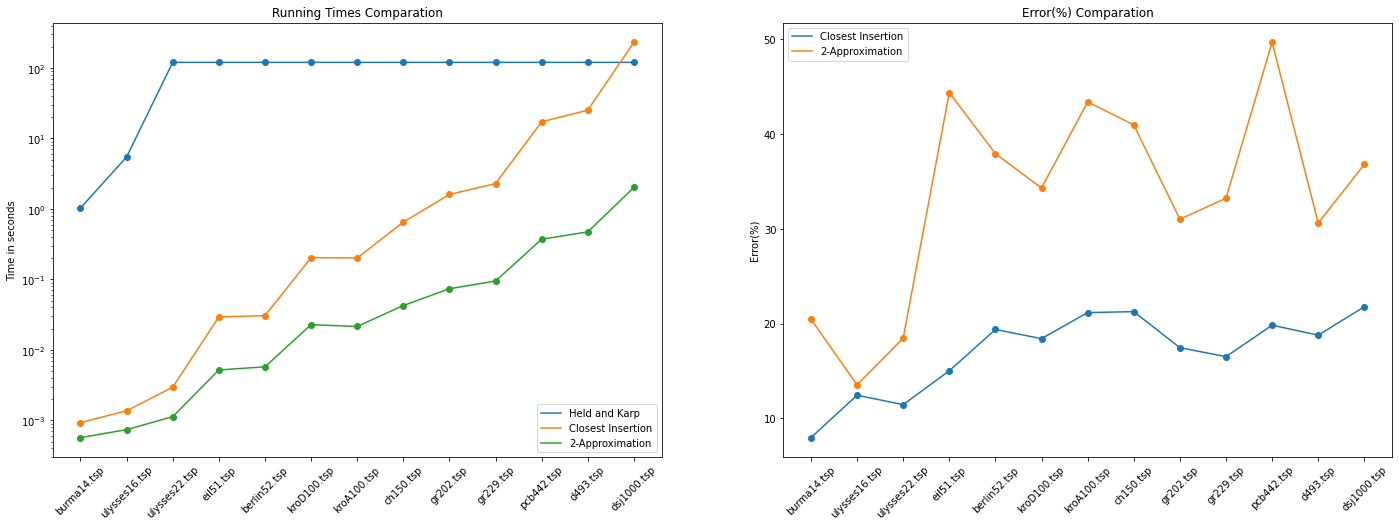

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1,ax2=ax

fig.set_figwidth(24)
fig.set_figheight(8)

ax1.plot(list(names), held_karp_times)
ax1.scatter(list(names), held_karp_times)
ax1.plot(list(names), closest_times)
ax1.scatter(list(names), closest_times)
ax1.plot(list(names), two_approximation_times)
ax1.scatter(list(names), two_approximation_times)

ax2.plot(list(names), closest_errors)
ax2.scatter(list(names), closest_errors)
ax2.plot(list(names), two_approximation_errors)
ax2.scatter(list(names), two_approximation_errors)

ax1.set_xticklabels(list(names),rotation=45)
ax2.set_xticklabels(list(names),rotation=45)

ax1.legend(['Held and Karp', "Closest Insertion","2-Approximation"])
ax1.set_title("Running Times Comparation")
ax1.set_ylabel("Time in seconds")
ax1.set_yscale("log")

ax2.set_title("Error(%) Comparation")
ax2.legend(["Closest Insertion","2-Approximation"])
ax2.set_ylabel("Error(%)")

fig.show()

From this graphs we can clearly see that:
* **Held and Karp** terminates only on the first two smallest datasets
* Running Time of **Closest Insertion** grows much more quicker than the **2-approximation** algorithm with respect of the number of nodes.
* The **Closest Insertion** Algorithm peforms always better than **2-approximation** in terms of error percentage.



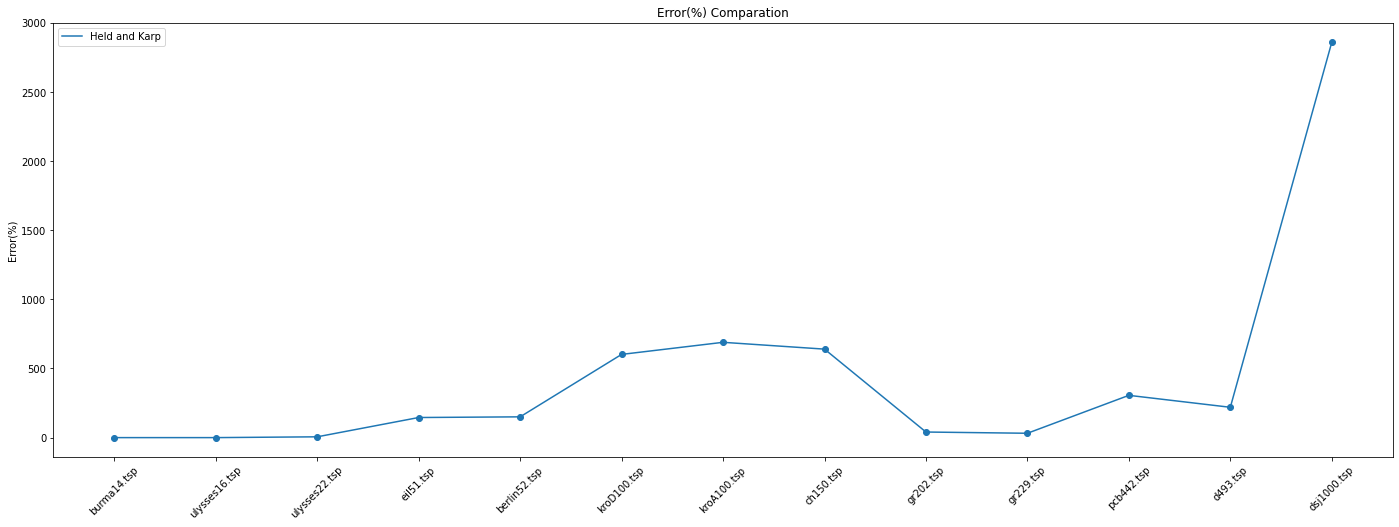

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1)

fig.set_figwidth(24)
fig.set_figheight(8)

ax.plot(list(names), held_karp_errors)
ax.scatter(list(names), held_karp_errors)

ax.set_xticklabels(list(names),rotation=45)
ax.set_title("Error(%) Comparation")
ax.set_ylabel("Error(%)")
ax.legend(["Held and Karp"])

fig.show()

We plotted on a different graph the Error percentage of **Held and Karp** since the results obtained where too random and became too big too fast.

# Credits

This notebook was realized by:
* **Giacomo Barzon**  (1236597)
* **Diego Mazzalovo** (1236592)
* **Giacomo Greggio** (1234236)